## A (very) brief introduction to Color Doppler 

Color doppler is a medical imaging modality for blood flow imaging.  
It bases on the Doppler effect.  
Doppler effect is a shift of a received signal frequency, when the wave source is moving relatively to the receiver.  
In medicine 'sources' (i.e. moving tissue, specifically blood) do not emits acoustic waves, but are 'iluminated' by a ultrasound pulses produced by a probe.  
It can be shown [Evans2000] that the shift in the received frequency is given by following equation:

$
f_d = f_t - f_r = \frac{2f_tv\cos{\alpha}}{c}
$

where
* $f_d$ - frequency shift, or doppler frequency,
* $f_t$ - transmitted frequency, 
* $f_r$ - received frequency, 
* $v$ - speed of the blood,
* $\alpha$ - the angle between the ultrasound beam and the direction of motion of the blood,
* $c$ - speed of sound in the medium. It is usually assumed that in soft tissue $c = 1540 [m/s]$.



<!-- When the medical probe transmits the ultrasound pulse, and it is scattered on moving blood (i.e. on blood cells), the received echoes changes in phase.    -->
In classical approach the probe transmits a series of (quite long) ultrasound pulses, receiving echoes after each transmit.  
The series consists of $N$ transmit/receive (TR) events, and the higher $N$, the higher sensitivity, but lower doppler framerate.  
Typically $N$ could be in the range of $8-16$ for classical methods and $32-256$ for synthetic aperture methods, however there are no strict rules.  
The TR events in the series are repeated with constant Pulse Repetition Frequency (PRF).  
Thus the time between TR events - Pulse Repetition Interval (PRI) is equal $\frac{1}{PRF}$.  
The received signals are IQ demodulated. Then, the high-pass filter in 'slow time' (the so-called wall clutter filter) is used.  
This filter is used for removing the constant echoes from non-flowing medium.  
The $f_d$ can be estimated from high-pass filtered IQ signal by means of autocorrelation esitmator:  

$
\overline{f_d} = \frac{1}{2\pi{}PRI} 
    \tan^{-1}{\left\{ 
        \frac{\sum^{N}_{i=1}{Q(i)I(i-1) - I(i)Q(i-1)}}
             {\sum^{N}_{i=1}{I(i)I(i-1) + Q(i)Q(i-1)}}
    \right\}}
$



<!-- , and next the phase is estimated for each sample.  
Then, for each sample the phase changes $\Delta{\theta}$ from TR to TR are calculated. Sometimes it is refered as phase changes in 'slow time'.  
The doppler frequency (averaged over time) can be calculated from the formula

$
\overline{f_d} = \frac{1}{N-1} \sum_{n=1}^{N-1} \frac{\Delta{\theta}_{n}}{PRI}
$

 -->
Then, we can use the following formula to estimate (average) speed of the blood flow.  

$
v_s = \frac{\overline{f_d}}{f_t} \frac{c}{2\cos{\alpha}}
$





The second mode used in medical flow imaging is power doppler, i.e. the power of the doppler signal.  
The power $p$ can be estimated using following estimator:

$
p = \sum^{N}_{i=1}{I(i)I(i) + Q(i)Q(i)}
$

The $p$ will be used to create a mask when displaying the flow - only those areas with adequate doppler signal strength will be displayed.


--------------------------------------------------------------------------------

In [1]:
import cupy as cp
import numpy as np
import scipy.signal as spsig
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import (

#     show_flow,
    filter_wall_clutter_gpu,
    iq2bmode_gpu,
    show_cineloop,
)
from matplotlib import animation
from IPython.display import HTML


def dB(data, mx=1):
    return 20*np.log10(data/mx)

def power_mask(data, power_dB, power_limit):
    mask = (power_dB < power_limit[0]) | (power_dB >= power_limit[1])
    img = np.copy(data)
    img[mask] = None
    return img

def scale_doppler(doppler_data, doppler_type):
    
    if doppler_type == 'color':
        doppler_scaled = doppler_data

    elif doppler_type == 'doppler frequency':
        doppler_scaled = doppler_data*1e-3

    elif doppler_type == 'speed':
        doppler_scaled = doppler_data*1e3

    elif doppler_type == 'power':
        doppler_scaled = doppler_data

    else:
        raise ValueError("The 'doppler_type' parameter should be one of the following: "
                         "'color', 'power', 'speed', 'doppler frequency'. ")
    return doppler_scaled

def prepare_doppler(doppler_array, power_dB, power_limit, doppler_type):
    doppler_array = scale_doppler(doppler_array, doppler_type)
    return  power_mask(doppler_array, power_dB, power_limit)
    
    
        
        

def show_flow(
    bmode, color, power_dB,
    xgrid=None,
    zgrid=None,
    doppler_type='power',
    power_limit=26,
    color_limit=None,
    bmode_limit=(-60,0),
):
    
    '''
    The function show blood flow on the b-mode image.

    :param bmode: bmode data array,
    :param color: color data array,
    :param power: power data array,
    :param xgrid: (optional) vector of 'x' coordinates,
    :param zgrid: (optional) vector of 'z' coordinates,
    :param doppler_type:(optional) type of flow presentation,
        the following types are possible:
        1. 'color' - raw color estimate [radians],
        2. 'doppler frequency' - color scaled in [kHz],
        3. 'power' - raw power estimate,
        4. 'speed' - color scaled in [mm/s],
    :param power_limit: (optional) flow estimate pixels corresponding to
                            power outside power_limit will not be shown,
    :param color_limit: (optional) two element tuple with color limit,
    :param bmode_limit: (optional) two element tuple with bmode limit.


    '''
    
#     power = dB(power)

    if doppler_type == 'power':
        doppler_array = power_dB
    else:
        doppler_array = color    
    

    if xgrid is not None and zgrid is not None:
        # convert grid from [m] to [mm]
        xgrid = xgrid*1e3
        zgrid = zgrid*1e3
        extent = (min(xgrid), max(xgrid), max(zgrid), min(zgrid))

        # calculate data aspect for proper image proportions
        dx = xgrid[1]-xgrid[0]
        dz = zgrid[1]-zgrid[0]
        data_aspect = dz/dx
        xlabel = '[mm]'
        ylabel = '[mm]'

    else:
        data_aspect = None
        extent = None
        xlabel = 'lines'
        ylabel = 'samples'
        
        

    if doppler_type == 'color':
        cmap = 'bwr'
        title = 'color doppler'
        cbar_label = '[radians]'
        if color_limit is None:
            color_limit = (-1., 1.)

    elif doppler_type == 'doppler frequency':
        cmap = 'bwr'
        title = 'color doppler'
        cbar_label = '[kHz]'
        if color_limit is None:
            color_limit = (-1, 1)

    elif doppler_type == 'speed':
        cmap = 'bwr'
        title = 'color doppler'
        cbar_label = '[mm/s]'
        if color_limit is None:
            color_limit = (-40, 40)

    elif doppler_type == 'power':
        cmap = 'hot'
        title = 'power doppler'
        cbar_label = '[dB]'
        color_limit = None

    else:
        raise ValueError("The 'doppler_type' parameter should be one of the following: "
                         "'color', 'power', 'speed', 'doppler frequency'. ")

    if color_limit is not None:
        vmin = color_limit[0]
        vmax = color_limit[1]

    else:
        vmin = None
        vmax = None
        
    doppler_array = prepare_doppler(doppler_array, power_dB, power_limit, doppler_type)

    bimg = plt.imshow(
        bmode,
        interpolation='bicubic',
        aspect=data_aspect,
        cmap='gray',
        extent=extent,
        vmin=bmode_limit[0],
        vmax=bmode_limit[1],
    )

    fimg = plt.imshow(
        doppler_array,
        interpolation='bicubic',
        aspect=data_aspect,
        cmap=cmap,
        extent=extent,
        vmin=vmin, vmax=vmax,
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
#     cbar = plt.colorbar(fimg,
#                         location='bottom',
#                         pad=0.2,
#                         aspect=20,
#                         fraction=0.05,
#                         label=cbar_label,
#                         )
#     cbar.set_label(cbar_label)
#     plt.show
    return bimg, fimg, doppler_array
    
def show_flow_cineloop(
    bmode, doppler_array, power,
    xgrid=None,
    zgrid=None,
    doppler_type='power',
    power_limit=26,
    color_limit=None,
    bmode_limit=(-60,0)):
    
    def init():
#         _, _, masked_doppler = show_flow(
#         bmode[:, :, 0], 
#         color[:, :, 0], 
#         power[:, :, 0],
#         xgrid=xgrid,
#         zgrid=zgrid,
#         doppler_type=doppler_type,
#         power_limit=power_limit,
#         color_limit=color_limit,
#         bmode_limit=bmode_limit,
#     )

        bimg.set_data(bmode[:, :, 0])
        fimg.set_data(masked_doppler)
        return (fimg, )

    def animate(frame):
#         _, _, masked_doppler = show_flow(
#         bmode[:, :, frame], 
#         color[:, :, frame], 
#         power[:, :, frame],
#         xgrid=xgrid,
#         zgrid=zgrid,
#         doppler_type=doppler_type,
#         power_limit=power_limit,
#         color_limit=color_limit,
#         bmode_limit=bmode_limit,
#     ) 
        masked_doppler = prepare_doppler(
            doppler_array[:, :, frame], 
            dB(power[:, :, frame]), 
            power_limit, 
            doppler_type,
        )
        bimg.set_data(bmode[:, :, frame])
        fimg.set_data(masked_doppler)
        return (fimg, )
        
#     power_dB = dB(power)
    fig, ax = plt.subplots()
    bimg, fimg, masked_doppler = show_flow(
        bmode[:, :, 0], 
        doppler_array[:, :, 0], 
        dB(power[:, :, 0]),
        xgrid=xgrid,
        zgrid=zgrid,
        doppler_type=doppler_type,
        power_limit=power_limit,
        color_limit=color_limit,
        bmode_limit=bmode_limit,
    )
    
    return animation.FuncAnimation(
        fig, animate, init_func=init, frames=bmode.shape[-1],
        interval=1, blit=True)
     

#     return animation.FuncAnimation(
#         fig, animate, init_func=init, frames=bmode.shape[-1],
#         interval=1, blit=True)        
        
        

def show_cineloop(imgs, value_range=None, cmap=None, figsize=None,
                  interval=50, xlabel="Azimuth (mm)", ylabel="Depth (mm)",
                  extent=None):

    def init():
        img.set_data(imgs[0])
        return (img,)

    def animate(frame):
        img.set_data(imgs[frame])
        return (img,)

    fig, ax = plt.subplots()
    if figsize is not None:
        fig.set_size_inches(figsize)
    img = ax.imshow(imgs[0], cmap=cmap, extent=extent)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if value_range is not None:
        img.set_clim(*value_range)

    return animation.FuncAnimation(
        fig, animate, init_func=init, frames=len(imgs),
        interval=interval, blit=True)





#### Kernel definition
The following kernel estimate both (non-scaled) doppler frequency and the power.  
Since similar data is used to estimate both, this is more optimal than creating two separate kernels.  

In [2]:
source = r"""

#include <cupy/complex.cuh>
extern "C" __global__ 
void doppler(float *color, 
             float *power, 
             const complex<float> *iqFrames, 
             const int nFrames, 
             const int nx, 
             const int nz, 
             const int nBatchFrames,
             const int step)
                  
{
    int z = blockIdx.x * blockDim.x + threadIdx.x;
    int x = blockIdx.y * blockDim.y + threadIdx.y;
    int t = blockIdx.z * blockDim.z + threadIdx.z;
    int nBatch = (nFrames - nBatchFrames)/step + 1;
    
    if (z >= nz || x >= nx || t >= nBatch) {
        return;
    }
    
    /* Color estimation */
        
    complex<float> iqCurrent, iqPrevious;
    float ic, qc, ip, qp, pwr, nom = 0.0f, den = 0.0f;

    iqCurrent = iqFrames[z + x*nz + t*nx*nz*step];
    ic = real(iqCurrent);
    qc = imag(iqCurrent);
    pwr = ic*ic + qc*qc;
    
    for (int iFrame = 1; iFrame < nBatchFrames; iFrame++) {
        // previous I and Q values
        ip = ic;
        qp = qc;
        
        // current I and Q values
        iqCurrent = iqFrames[z + x*nz + t*nx*nz*step + iFrame*nz*nx];
        ic = real(iqCurrent);
        qc = imag(iqCurrent);
        
        pwr += ic*ic + qc*qc;
        den += ic*ip + qc*qp;
        nom += qc*ip - ic*qp;
    }
    color[z + x*nz + t*nx*nz] = atan2f(nom, den);
    power[z + x*nz + t*nx*nz] = pwr/nFrames;
}

"""
doppler = cp.RawKernel(source, 'doppler')


## Data processing for Color Doppler

#### Data loading

These 512 frames of IQ data were acquired from carotid artery of healthy volunteer.  
The single plane wave imaging (PWI) scheme was used.  
Transmit angle was about 20 degree, and receive angle was equal 0 degree.


The image below show the vessel as a darker region between 3-5 mm depth.   
The white triangle in the upper-left corner, and the rectangle at 0-1 mm depth are artifacts - ignore them. 
<!-- ![title](data/bmode.jpg) -->

<img src="data/bmode.jpg" width="400">

In [3]:
data = np.load('data/example_doppler_data.npz')
# data = np.load('data/npz/iqImgPK_batch01.npz')
iq = data['iq'] # frames of IQ data
xgrid = data['xgrid'] # vector of 'x' coordinates
zgrid = data['zgrid'] # vector of 'z' coordinates
prf = data['prf'] # pulse repetition frequency
c = data['c'] # speed of sound
tx_frequency = data['tx_frequency'] # transmit frequency


#### Color doppler estimation using defined kernel

In [4]:
# push iq data into gpu
iq_gpu = cp.array(iq)

# apply wall clutter filter
%time iq_wcfilt = filter_wall_clutter_gpu(iq_gpu, Wn=0.19, N=128)


CPU times: user 472 ms, sys: 389 µs, total: 473 ms
Wall time: 473 ms


In [5]:
# allocate memory on gpu for output data
nframes, nx, nz = iq_wcfilt.shape

nbatchframes = 128
step = 16
nstep = np.floor((nframes - nbatchframes)/step).astype(int)
nbatch = nstep + 1
color =  cp.zeros((nbatch, nx, nz)).astype(cp.float32)
power =  cp.zeros((nbatch, nx, nz)).astype(cp.float32)

# specify block and grid sizes
bx = 16
bz = 16
bt = 4
gx = np.ceil(nx/bx).astype(int)
gz = np.ceil(nz/bx).astype(int)
gt = np.ceil(nbatch/bt).astype(int)
block = (bz, bx, bt)
grid = (gz, gx, gt)

# use kernel (and measure working time)
%time doppler(grid, block, (color, power, iq_wcfilt, nframes, nx, nz, nbatchframes, step))

# get data from gpu
color = color.get().T
power = power.get().T


CPU times: user 804 µs, sys: 0 ns, total: 804 µs
Wall time: 708 µs


#### color scaling

In [6]:
# The transmit angle was ~20deg, receive angle was 0deg - lets assume 10deg effective angle
alpha = 10/180*np.pi

# doppler frequency
fd = prf/2/np.pi*color # [Hz]

# blood speed
v = fd/tx_frequency*c/2/np.cos(alpha)


#### Presentation of results 

In [7]:
# Make b-mode arrays from non-filtered iq data,  and get it from gpu.
# Each b-mode array corresponds to data from the center of each batch.
bmode = np.zeros_like(color)
batch_center_frame = np.round(nbatchframes/2).astype(int)
for ibatch in range(nbatch):
    iframe = ibatch*step + batch_center_frame
    bmode[:,:,ibatch] = iq2bmode_gpu(iq_gpu[iframe,:,:]).get().T


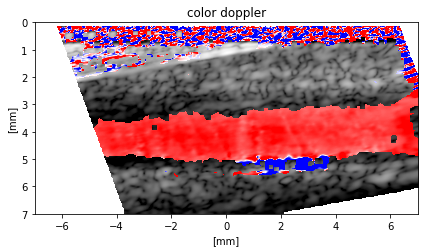

In [8]:
# make b-mode array from non-filtered iq data and get it from gpu
ibatch = 0
# if ibatch > nbatch:
#     raise ValueError(f"ibatch ({ibatch}) must be  less than or equal nbatch ({nbatch})")
    
# batch_center_frame = np.round(nbatchframes/2).astype(int)
# iframe = ibatch*step + batch_center_frame
# bmode = iq2bmode_gpu(iq_gpu[iframe,:,:]).get().T

# set parameters for show_flow() function
bmode_limit = (-60, 0)
power_limit = (12, 42)

doppler_type = 'speed'
# doppler_type = 'power'
# doppler_type = 'doppler frequency'
# doppler_type = 'color'

pdata = dB(power[:,:,ibatch])
bdata = bmode[:,:,ibatch]
if doppler_type == 'speed':
    cdata = v[:,:,ibatch] 
    
elif  doppler_type == 'power':
    cdata = []

elif  doppler_type == 'doppler frequency':
    cdata = fd[:,:,ibatch]

elif  doppler_type == 'color':
    cdata = color[:,:,ibatch]

# final image
bimg, fimg, masked_doppler = show_flow(
    bdata, cdata, pdata, 
    xgrid, zgrid,
    doppler_type=doppler_type,
    power_limit=power_limit,
    bmode_limit=bmode_limit)

# bimg.set_data(np.zeros_like(bdata))

<class 'numpy.ndarray'>
(281, 561)


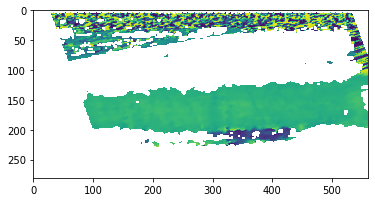

In [9]:
print(type(masked_doppler))
print(masked_doppler.shape)
plt.imshow(masked_doppler)

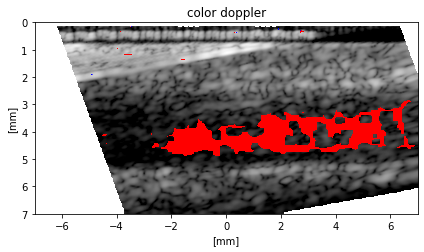

In [10]:
# show_flow_cineloop(bdata, cdata, pdata, 
#           xgrid, zgrid,
#           doppler_type=doppler_type,
#           power_limit=power_limit,
#           bmode_limit=bmode_limit)

# for ibatch in range(nbatch):
#     show_flow(bmode[:,:,ibatch], color[:,:,ibatch], power[:,:,ibatch], 
#           xgrid, zgrid,
#           doppler_type=doppler_type,
#           power_limit=power_limit,
#           bmode_limit=bmode_limit)

ibatch = 0
fig, bimg, fimg = show_flow(bmode[:,:,ibatch], color[:,:,ibatch], power[:,:,ibatch], 
    xgrid, zgrid,
    doppler_type='speed',
    power_limit=power_limit,
    bmode_limit=bmode_limit)

# for ibatch in range(nbatch):
#     bimg.set_data(bmode[:, :, ibatch])
# #     fimg.set_data(color[:, :, 0])
#     plt.show
# bimg.set_data(np.zeros_like(bdata))

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


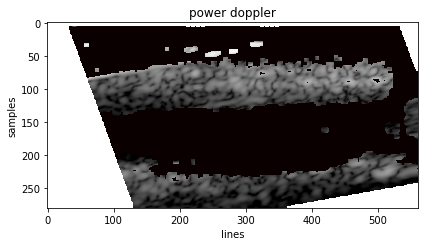

In [11]:
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib inline

anim = show_flow_cineloop(
    bmode, color, power,
    xgrid=None,
    zgrid=None,
    doppler_type='power',
    power_limit=(6,36),
    color_limit=None,
    bmode_limit=(-60,0),
)

# plt.show()
print(animation.writers.list())
# plt.close(anim._fig)
HTML(anim.to_html5_video())
# HTML(anim.to_jshtml())
# anim._repr_html_() is None
# animation.html.rc('animation', html='html5')
# anim.save('double_pendulum.xvid', writer='pillow', fps=15)

-----------------------------------------

### References

[Evans2000] Evans, David H., and W. Norman McDicken. Doppler ultrasound: physics, instrumentation and signal processing. Wiley-Blackwell, 2000.